<a href="https://colab.research.google.com/github/Abghari-Mohsen/cs231n-ass1/blob/main/kNN_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Colab_Projects/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Colab_Projects/assignment1/cs231n/datasets
/content/drive/My Drive/Colab_Projects/assignment1


# k-Nearest Neighbor (kNN)

The nearest neighbor classifier will take a test image, compare it to every single one of the training images, and predict the label of the closest training image. One of the simplest possibilities is to compare the images pixel by pixel and add up all the differences. In other words, given two images and representing them as vectors $I_1$,$I_2$, a reasonable choice for comparing them might be the $L_1$ and $L_2$ distances: $$ L_1: d_1(I_1,I_2)=\sum_p |I_1^p-I_2^p| $$ and $$ L_2: d_2(I_1,I_2)=\sqrt {\sum_p |I_1^p-I_2^p|^2} $$

You may have noticed that it is strange to only use the label of the nearest image when we wish to make a prediction. Indeed, it is almost always the case that one can do better by using what’s called a **k-Nearest Neighbor Classifier**. The idea is very simple: instead of finding the single closest image in the training set, we will find the top k closest images, and have them vote on the label of the test image.

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [ ]:
import matplotlib
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [ ]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

# When you run a cell that generates a Matplotlib plot, this command will render
# the plot within the notebook itself. Without this command, your plots may (some
# of the notebooks and IDEs use matplotlib inline in their backend and you do not
# notice the difference between normal matplotlib and matplotlib inline. To check it
# use the follwing command "print(matplotlib.get_backend())")
# appear in a separate window or not appear at all.
# %matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


# Image representaion as an array

As you can see the shape of data are (n,q,p,c).

First, I start from the last number (c) which **always** represents the number of columns in any array representation and as an image it stands for primary colors (RGB - red, green, and blue).
So these three numbers quantify the intensity of Red, Gree, and Blue parts of each pixel in the image. Here, our array have three columns where each one represents Red, Green, and Blue intensities.

Secondly, p indicates the number of rows as we must expected from 2D array (a mtrx). q shows the number of matrices in each image. Actually, q*p represents the number of pixels in each color layer of an image. For instance X_train[0,:,:,0] is matrix containing Red intensities of 32*32 pixels of the first image.

Ultimately, n stands for the number of images here 50_000 in the training set.

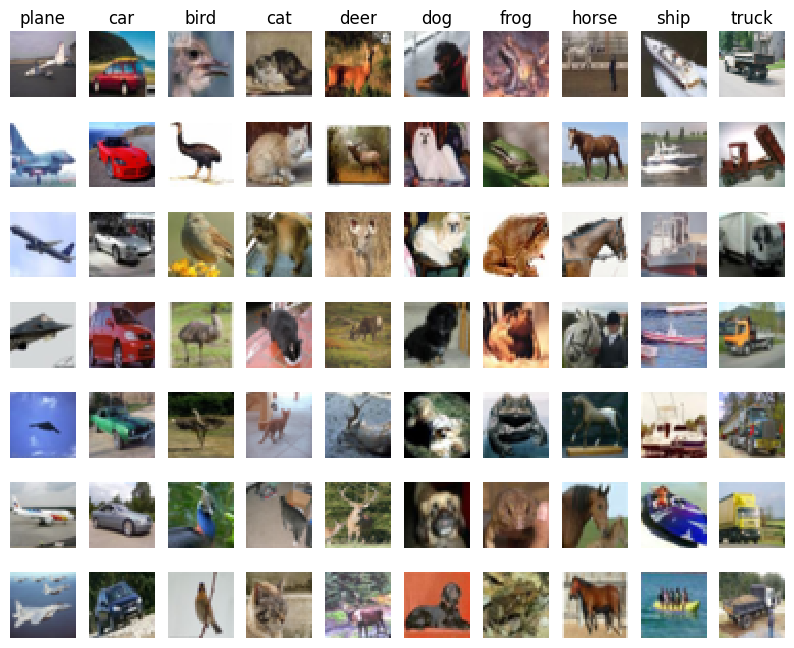

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.

# The instructor exactly knows the name of each class (label). You can also find
# this out by checking the following websites: https://www.cs.toronto.edu/~kriz/cifar.html or comparing unique labels with their images.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    # print(y,cls)
    idxs = np.flatnonzero(y_train == y) # Pick index of all images belong to the same category in a one dimenssional array
    idxs = np.random.choice(idxs, samples_per_class, replace=False) # Pick only seven index of a label without replacement (it is not possible to pick up a same element--here index--two times)
    # print(idxs)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        # print(plt_idx)
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
# print(mask)
X_tr = X_train[mask]
# print(X_train.shape)
y_tr = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_te = X_test[mask]
y_te = y_test[mask]

# Reshape the image data into rows
# Note that we must specify tuple numbers in which their products is equal to the total number of elements
X_tr = np.reshape(X_tr, (X_tr.shape[0], -1)) # any minus number handle to include all data
X_te = np.reshape(X_te, (X_te.shape[0], -1))
print(X_tr.shape, X_te.shape)

(5000, 3072) (500, 3072)


In [ ]:
class MyKNearestNeighbor:
    def __init__(self):
      pass

    def train(self,x,y):
      self.x_tr = x
      self.y_tr = y

    def compute_distance_l1_two_loops(self,x):
        dists_l1 = np.zeros((x.shape[0],self.x_tr.shape[0]))
        for i,test in enumerate(x):
            for j,train in enumerate(self.x_tr):
                dists_l1[i,j] = np.sum(np.absolute(train-test))
        return dists_l1

    def compute_distance_l2_two_loops(self,x):
        dists_l2 = np.zeros((x.shape[0],self.x_tr.shape[0]))
        for i,test in enumerate(x):
            for j,train in enumerate(self.x_tr):
                dists_l2[i,j] = np.sum(np.square(train-test))
        return dists_l2

    def compute_distance_l1_one_loop(self,x):
        dists_l1 = np.zeros((x.shape[0],self.x_tr.shape[0]))
        for idx,row in enumerate(x):
            dists_l1[idx,:] = np.sum(np.absolute(self.x_tr-row),axis=1)
        return dists_l1

    def compute_distance_l2_one_loop(self,x):
        dists_l2 = np.zeros((x.shape[0],self.x_tr.shape[0]))
        for idx,row in enumerate(x):
            dists_l2[idx,:] = np.sum(np.square(self.x_tr-row),axis=1)
        return dists_l2

    def compute_distance_l1(self,x):
        pass

    def compute_distance_l2(self,x):
        pass

    def predict_labels(self,y,dists,k=1):
        y_pred = np.zeros(y.shape)
        for i in range(y.shape[0]):
            idx = np.argpartition(dists[i,:],k) # returns indices of all elements smaller than the kth element where kth element is in its sorted position while smaller elements are not necessarily sorted in order
            kNearest = self.y_tr[idx[:k]] # idx[:k] indicate all indices of elements smaller than kth element and Y_tr[idx[:k]] returns labels corresponding to the kth small elements
            y_pred[i] =  np.bincount(kNearest).argmax() # return the most frequent label which would be our prediction based on KNN algorithm
        return y_pred

In [ ]:
myClassifier = MyKNearestNeighbor()
myClassifier.train(X_tr,y_tr)

In [ ]:
%timeit myClassifier.compute_distance_l1_two_loops(X_te)
%timeit myClassifier.compute_distance_l1_one_loop(X_te)
%timeit myClassifier.compute_distance_l2_two_loops(X_te)
%timeit myClassifier.compute_distance_l2_one_loop(X_te)

21.2 s ± 596 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
25.6 s ± 414 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
22 s ± 386 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
25.5 s ± 1.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
dists_l1_two_loops = myClassifier.compute_distance_l1_two_loops(X_te)
dists_l2_two_loops = myClassifier.compute_distance_l2_two_loops(X_te)

dists_l1_one_loop = myClassifier.compute_distance_l1_one_loop(X_te)
dists_l2_one_loop = myClassifier.compute_distance_l2_one_loop(X_te)

print(dists_l1_two_loops == dists_l1_one_loop)
print(dists_l2_two_loops == dists_l2_one_loop)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [ ]:
dists_l1 = myClassifier.compute_distance_l1_one_loop(X_te)
print(dists_l1)
print(dists_l1.shape)
dists_l2 = myClassifier.compute_distance_l2_one_loop(X_te)
print(dists_l2)
print(dists_l2.shape)

[[167664. 188615. 240781. ... 179399. 196712. 202970.]
 [299995. 242668. 178870. ... 224700. 217865. 385475.]
 [237506. 188165. 168501. ... 171101. 204114. 296450.]
 ...
 [241463. 229618. 307496. ... 238764. 214037. 268735.]
 [161986. 171691. 229345. ... 164213. 140094. 210722.]
 [356015. 293736. 302686. ... 289506. 190133. 401109.]]
(500, 5000)
[[14469834. 17729119. 30294615. ... 16061239. 17667570. 18959080.]
 [40155461. 27775852. 16326740. ... 23320722. 22034553. 60347005.]
 [27298944. 18067965. 14242667. ... 14188899. 19936218. 40367876.]
 ...
 [28803995. 25632726. 40473234. ... 26281702. 20587147. 35057549.]
 [13483064. 14888853. 23492261. ... 12397759. 10127462. 19790514.]
 [48454469. 37011572. 40171948. ... 37009642. 17042427. 64658521.]]
(500, 5000)


(218, 1387)


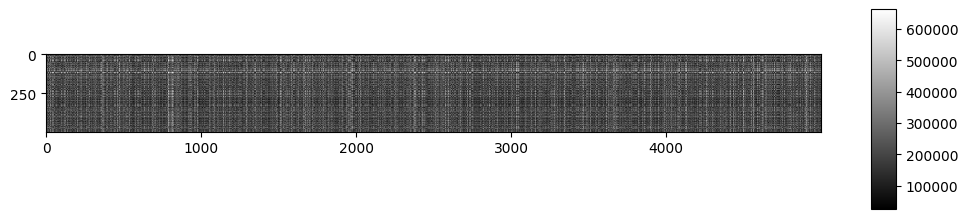

In [ ]:
print(np.unravel_index(dists_l1.argmax(),dists_l1.shape))
plt.imshow(dists_l1, interpolation='none') # imshow is useful for plot images and any 2D scalar as an image
# plt.subplots_adjust(bottom=0.25, right=0.8, top=0.9)
cax = plt.axes((0.95, 0.35, 0.025, 0.25)) #4-tuple of floats rect = (left, bottom, width, height)
plt.colorbar(cax=cax)
plt.show()

(385, 4940)


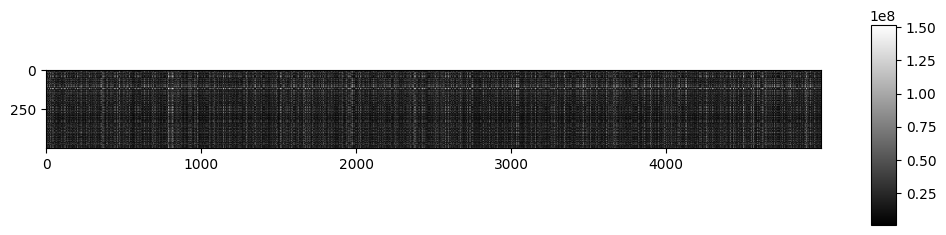

In [ ]:
print(np.unravel_index(dists_l2.argmax(),dists_l2.shape))
plt.imshow(dists_l2, interpolation='none')
# plt.subplots_adjust(bottom=0.25, right=0.8, top=0.9)
cax = plt.axes((0.95, 0.35, 0.025, 0.25)) #4-tuple of floats rect = (left, bottom, width, height)
plt.colorbar(cax=cax)
plt.show()

In [ ]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [ ]:
# %timeit classifier.compute_distances_two_loops(X_test)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [ ]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# # Test your implementation:
# dists = classifier.compute_distances_two_loops(X_test)
# print(dists.shape)

# print(dists)

# # We can visualize the distance matrix: each row is a single test example and
# # its distances to training examples
# plt.imshow(dists, interpolation='none')
# plt.show()

pass # Since I wrote my own class as MyKNearestNeighbor

**Inline Question 1**

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?


$\color{blue}{\textit Your Answer:}$ *.*
> It is due to the fact that the given test example shows large distance (l1 or/and l2) relative to **all** of the given training example. **This means that the given test image is not similar to any given training images based on l1 or l2 distances of KNN**.

> This is because the distance of a given training example (l1 or/and l2) relative to **all** given test examples is so large. **It means that the given image does not look like any of the test images based on l1 or l2 distances of KNN**.


In [ ]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = myClassifier.predict_labels(y_te,dists_l2)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_te)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f -- l2 criteria' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000 -- l2 criteria


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [ ]:
y_test_pred = myClassifier.predict_labels(y_te,dists_l2,k=5)
num_correct = np.sum(y_test_pred == y_te)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [ ]:
# My test for a large k
for k in [10,20,50,100]:
  y_test_pred = myClassifier.predict_labels(y_te,dists_l2,k=k)
  num_correct = np.sum(y_test_pred == y_te)
  accuracy = float(num_correct) / num_test
  print('for %d Got %d / %d correct => accuracy: %f' % (k,num_correct, num_test, accuracy))

for 10 Got 141 / 500 correct => accuracy: 0.282000
for 20 Got 136 / 500 correct => accuracy: 0.272000
for 50 Got 126 / 500 correct => accuracy: 0.252000
for 100 Got 111 / 500 correct => accuracy: 0.222000


**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$

$\color{red}{MyMisunderstanding:}$ I have a problem with the definition of the mean over all pixels of all images. When we say over all pixels, the mean calculation must mix all pixels of the RGB layers while this point is not considered in the aforementioned formulae not in the denominator nor in the indices. Moreover, the left side of the equation the mean has no index of RGB colors. So, I think that I have to mean across all pixels of all color layres over all images. But, I think the denominator must be modified and also times to the three due to the existence of three layers RGB.
$\color{red}{EndOfMyMisunderstanding}$

The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.

$\color{blue}{\textit Your Answer:}$
I think methods 1, 2, and 5 will not change the performance of Nearest Neighbor classifier with l1 distance metric. However, methods 3 and 4 may change.

$\color{blue}{\textit Your Explanation:}$
This is because methods 1 and 2 only shift each pixel in both training and test with a same amount which cancel out. The rotation approach also acts like a coefficient. It means that the l1 distance matrix remains constant and only times to a constant value which can be factored. So the perfromance not changed.

For $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.): $$ l_1^{new} = \sum_p|I_1^p - \mu - I_2^p + μ| = \sum_p|I_1^p - I_2^p| = l_1 $$

For $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.) $$ l_1^{new} = \sum_p|I_1^p - \mu_{ij} - I_2^p + μ_{ij}| = \sum_p|I_1^p - I_2^p| = l_1 $$

According to the image rotation links the value of each pixel does not change under coordinate axes rotation. So the values of l1 distance matrix are invariante under pure rotation. As a result, it does not influence on the performance of the model.

matrix rotation - mathematics representation:
> https://en.wikipedia.org/wiki/Rotation_matrix

> https://www.cuemath.com/algebra/rotation-matrix/

**image rotation**:
> http://datagenetics.com/blog/august32013/index.html

> https://homepages.inf.ed.ac.uk/rbf/HIPR2/rotate.htm

However, the third and fourth methods could change the difference value between each two pixles in unpredictable manner. So, it might change the value of l1 and subsequently the final performance.

** To prove my claims, I am going to apply these transformation on the training and test data and check the results as well.



In [ ]:
# Subtracting the mean
mu = X_tr.mean()
X_tr_mean_free = X_tr - mu
X_te_mean_free = X_te - mu #We always be carfule to do not compute the mean for whole dataset. This is because we will mix features of test data with training data and can affect in our lagorithm and lead to overfitting

myClassifier = MyKNearestNeighbor()
myClassifier.train(X_tr_mean_free,y_tr)
dists_l1 = myClassifier.compute_distance_l1_one_loop(X_te_mean_free)
dists_l2 = myClassifier.compute_distance_l2_one_loop(X_te_mean_free)
y_test_pred_l1 = myClassifier.predict_labels(y_te,dists_l1)
y_test_pred_l2 = myClassifier.predict_labels(y_te,dists_l2)
num_correct_l1 = np.sum(y_test_pred_l1 == y_te)
num_correct_l2 = np.sum(y_test_pred_l2 == y_te)
accuracy_l1 = float(num_correct_l1) / num_test
accuracy_l2 = float(num_correct_l2) / num_test
print('Subtracting the mean')
print('Got %d / %d correct => accuracy: %f -- l1 criteria' % (num_correct_l1, num_test, accuracy_l1))
print('Got %d / %d correct => accuracy: %f -- l2 criteria' % (num_correct_l2, num_test, accuracy_l2))

# Subtracting the pixel wise mean
mu_ij = np.mean(X_tr,axis=0)
X_tr_mean_free_pw = X_tr - mu_ij
X_te_mean_free_pw = X_te - mu_ij

myClassifier = MyKNearestNeighbor()
myClassifier.train(X_tr_mean_free_pw,y_tr)
dists_l1 = myClassifier.compute_distance_l1_one_loop(X_te_mean_free_pw)
dists_l2 = myClassifier.compute_distance_l2_one_loop(X_te_mean_free_pw)
y_test_pred_l1 = myClassifier.predict_labels(y_te,dists_l1)
y_test_pred_l2 = myClassifier.predict_labels(y_te,dists_l2)
num_correct_l1 = np.sum(y_test_pred_l1 == y_te)
num_correct_l2 = np.sum(y_test_pred_l2 == y_te)
accuracy_l1 = float(num_correct_l1) / num_test
accuracy_l2 = float(num_correct_l2) / num_test
print('\n Subtracting the per pixel mean')
print('Got %d / %d correct => accuracy: %f -- l1 criteria' % (num_correct_l1, num_test, accuracy_l1))
print('Got %d / %d correct => accuracy: %f -- l2 criteria' % (num_correct_l2, num_test, accuracy_l2))

# Standardize the data (subtracting by mean and dividing by std)
std = X_tr.std() # std = np.sqrt(np.sum(np.square(X_tr_mean_free))/(X_tr.shape[0]*X_tr.shape[1]))
X_tr_standard = X_tr_mean_free/std
X_te_standard = X_te_mean_free/std

myClassifier = MyKNearestNeighbor()
myClassifier.train(X_tr_standard,y_tr)
dists_l1 = myClassifier.compute_distance_l1_one_loop(X_te_standard)
dists_l2 = myClassifier.compute_distance_l2_one_loop(X_te_standard)
y_test_pred_l1 = myClassifier.predict_labels(y_te,dists_l1)
y_test_pred_l2 = myClassifier.predict_labels(y_te,dists_l2)
num_correct_l1 = np.sum(y_test_pred_l1 == y_te)
num_correct_l2 = np.sum(y_test_pred_l2 == y_te)
accuracy_l1 = float(num_correct_l1) / num_test
accuracy_l2 = float(num_correct_l2) / num_test
print('\n Subtracting the mean and dividing by standard deviation - Standardization')
print('Got %d / %d correct => accuracy: %f -- l1 criteria' % (num_correct_l1, num_test, accuracy_l1))
print('Got %d / %d correct => accuracy: %f -- l2 criteria' % (num_correct_l2, num_test, accuracy_l2))

# Standardize pixel wise data
std_ij = np.sqrt(np.sum(np.square(X_tr_mean_free_pw),axis=0)/(X_tr.shape[0]*X_tr.shape[1]))
X_tr_pw_standardize = X_tr_mean_free_pw/std_ij
X_te_pw_standardize = X_te_mean_free_pw/std_ij

myClassifier = MyKNearestNeighbor()
myClassifier.train(X_tr_pw_standardize,y_tr)
dists_l1 = myClassifier.compute_distance_l1_one_loop(X_te_pw_standardize)
dists_l2 = myClassifier.compute_distance_l2_one_loop(X_te_pw_standardize)
y_test_pred_l1 = myClassifier.predict_labels(y_te,dists_l1)
y_test_pred_l2 = myClassifier.predict_labels(y_te,dists_l2)
num_correct_l1 = np.sum(y_test_pred_l1 == y_te)
num_correct_l2 = np.sum(y_test_pred_l2 == y_te)
accuracy_l1 = float(num_correct_l1) / num_test
accuracy_l2 = float(num_correct_l2) / num_test
print('\n Subtracting the per pixel mean and dividing by per pixel standard deviation')
print('Got %d / %d correct => accuracy: %f -- l1 criteria' % (num_correct_l1, num_test, accuracy_l1))
print('Got %d / %d correct => accuracy: %f -- l2 criteria' % (num_correct_l2, num_test, accuracy_l2))

# Rotating Pixels
## Rotating pixels must be done before flattening data
### Packages
# from PIL import Image ---- It rotate perfectly an image but I want to rotate the ndarray of images
# import cv2 -- OpenCV
# or use numpy np.rot90() to rotate an array by numpy
### I use cv2 and rotate all images 90 degree clock wise
import cv2
X_tr_rt = np.zeros((5000,X_train.shape[1],X_train.shape[2],X_train.shape[3]))
for i in range(5000):
    X_tr_rt[i,:] = cv2.rotate(X_train[i,:],cv2.ROTATE_90_CLOCKWISE)
X_tr_rt = np.reshape(X_tr_rt,(X_tr_rt.shape[0],-1))

X_te_rt = np.zeros((5000,X_test.shape[1],X_test.shape[2],X_test.shape[3]))
for i in range(500):
    X_te_rt[i,:] = cv2.rotate(X_test[i,:],cv2.ROTATE_90_CLOCKWISE)
X_te_rt = np.reshape(X_te_rt,(X_te_rt[i,:],-1))

myClassifier = MyKNearestNeighbor()
myClassifier.train(X_tr_rt,y_tr)
dists_l1 = myClassifier.compute_distance_l1_one_loop(X_te_rt)
dists_l2 = myClassifier.compute_distance_l2_one_loop(X_te_rt)
y_test_pred_l1 = myClassifier.predict_labels(y_te,dists_l1)
y_test_pred_l2 = myClassifier.predict_labels(y_te,dists_l2)
num_correct_l1 = np.sum(y_test_pred_l1 == y_te)
num_correct_l2 = np.sum(y_test_pred_l2 == y_te)
accuracy_l1 = float(num_correct_l1) / num_test
accuracy_l2 = float(num_correct_l2) / num_test
print('\n Rotating an image -- here 90 degree clockwise for simplicity')
print('Got %d / %d correct => accuracy: %f -- l1 criteria' % (num_correct_l1, num_test, accuracy_l1))
print('Got %d / %d correct => accuracy: %f -- l2 criteria' % (num_correct_l2, num_test, accuracy_l2))

Subtracting the mean
Got 145 / 500 correct => accuracy: 0.290000 -- l1 criteria
Got 137 / 500 correct => accuracy: 0.274000 -- l2 criteria

 Subtracting the per pixel mean
Got 145 / 500 correct => accuracy: 0.290000 -- l1 criteria
Got 137 / 500 correct => accuracy: 0.274000 -- l2 criteria

 Subtracting the mean and dividing by standard deviation - Standardization
Got 145 / 500 correct => accuracy: 0.290000 -- l1 criteria
Got 137 / 500 correct => accuracy: 0.274000 -- l2 criteria

 Subtracting the per pixel mean and dividing by per pixel standard deviation
Got 146 / 500 correct => accuracy: 0.292000 -- l1 criteria
Got 131 / 500 correct => accuracy: 0.262000 -- l2 criteria


TypeError: ignored